## Libraries


In [1]:
import random

# data manipulation libraries
import numpy as np
import pandas as pd

# machine learning libraries
import xgboost as xgb

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import heatmap

# deployment libraries
import onnxruntime as rt
import onnxmltools
from skl2onnx.common.data_types import FloatTensorType

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU


## Parameters


In [3]:
batch_size = 1024
learning_rate = 0.001
N_Epochs = 100
epsilon = 0.0001

## Read data


In [4]:
data_path = '../data/Chicago_Crimes_2018_to_2024.csv'
RAW_DATA = pd.read_csv(data_path, low_memory=False)

# Use only 2024 data
RAW_DATA = RAW_DATA[RAW_DATA['Year'] == 2024]

print("Shape of RAW_DATA:", RAW_DATA.shape)
RAW_DATA.head()

Shape of RAW_DATA: (258809, 22)


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
98,13709672,JJ101940,12/31/2024 11:58:00 PM,014XX E 68TH ST,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,...,5.0,43.0,14,1186817.0,1860189.0,2024,11/02/2025 03:41:09 PM,41.771470,-87.590742,"(41.771470188, -87.59074212)"
99,13707925,JJ100089,12/31/2024 11:56:00 PM,047XX S DR MARTIN LUTHER KING JR DR,1365,CRIMINAL TRESPASS,TO RESIDENCE,APARTMENT,True,True,...,3.0,38.0,26,1179661.0,1873623.0,2024,05/17/2025 03:40:52 PM,41.808501,-87.616563,"(41.808500903, -87.616562762)"
100,13708038,JJ100035,12/31/2024 11:55:00 PM,077XX S CICERO AVE,0498,BATTERY,"AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SE...",HOTEL / MOTEL,False,True,...,18.0,70.0,04B,1145740.0,1853048.0,2024,11/02/2025 03:41:09 PM,41.752749,-87.741498,"(41.752748627, -87.741497836)"
101,13709164,JJ101392,12/31/2024 11:53:00 PM,066XX S GREENWOOD AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,...,20.0,42.0,14,1184362.0,1861188.0,2024,11/02/2025 03:41:09 PM,41.774269,-87.599710,"(41.774269351, -87.599709962)"
102,13707823,JJ100020,12/31/2024 11:50:00 PM,012XX N MENARD AVE,0460,BATTERY,SIMPLE,SIDEWALK,False,False,...,29.0,25.0,08B,1137458.0,1907694.0,2024,05/17/2025 03:40:52 PM,41.902858,-87.770537,"(41.902858242, -87.770536741)"


In [5]:
columns_to_drop = [
    # IUCR is similar to Primary Type, Description is too granular
    'ID', 'Case Number', 'IUCR', 'Description',
    # Redundant or administrative data
    'X Coordinate', 'Y Coordinate', 'Location', 'Updated On',
]
PREPROCESS_DATA = RAW_DATA.drop(columns=columns_to_drop)

In [6]:
# Convert 'Date' to datetime objects
PREPROCESS_DATA['Date'] = pd.to_datetime(PREPROCESS_DATA['Date'])

# Extract useful time features
PREPROCESS_DATA['Hour'] = PREPROCESS_DATA['Date'].dt.hour
PREPROCESS_DATA['Day'] = PREPROCESS_DATA['Date'].dt.day_name()
PREPROCESS_DATA['Month'] = PREPROCESS_DATA['Date'].dt.month

# Drop the original 'Date' column
PREPROCESS_DATA = PREPROCESS_DATA.drop(columns=['Date'])

C:\Users\ikath\AppData\Local\Temp\ipykernel_34144\757837712.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  PREPROCESS_DATA['Date'] = pd.to_datetime(PREPROCESS_DATA['Date'])


In [7]:
# Columns with potential missing spatial/area data
area_cols = ['Latitude', 'Longitude', 'District', 'Ward', 'Community Area']

# Fill missing values with the mode (most frequent value)
for col in area_cols:
    # Convert to category/object first to ensure proper mode calculation
    PREPROCESS_DATA[col] = PREPROCESS_DATA[col].astype('category')
    mode_value = PREPROCESS_DATA[col].mode()[0]
    PREPROCESS_DATA[col] = PREPROCESS_DATA[col].fillna(mode_value)

# Convert these columns back to their appropriate type (numeric for coordinates, int for areas)
PREPROCESS_DATA['Latitude'] = PREPROCESS_DATA['Latitude'].astype(float)
PREPROCESS_DATA['Longitude'] = PREPROCESS_DATA['Longitude'].astype(float)
PREPROCESS_DATA['District'] = PREPROCESS_DATA['District'].astype(int)
PREPROCESS_DATA['Ward'] = PREPROCESS_DATA['Ward'].astype(int)
PREPROCESS_DATA['Community Area'] = PREPROCESS_DATA['Community Area'].astype(int)

In [8]:
PREPROCESS_DATA.head()

,Block,Primary Type,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Latitude,Longitude,Hour,Day,Month
98,014XX E 68TH ST,CRIMINAL DAMAGE,APARTMENT,False,False,332,3,5,43,14,2024,41.771470,-87.590742,23,Tuesday,12
99,047XX S DR MARTIN LUTHER KING JR DR,CRIMINAL TRESPASS,APARTMENT,True,True,223,2,3,38,26,2024,41.808501,-87.616563,23,Tuesday,12
100,077XX S CICERO AVE,BATTERY,HOTEL / MOTEL,False,True,834,8,18,70,04B,2024,41.752749,-87.741498,23,Tuesday,12
101,066XX S GREENWOOD AVE,CRIMINAL DAMAGE,STREET,False,False,321,3,20,42,14,2024,41.774269,-87.599710,23,Tuesday,12
102,012XX N MENARD AVE,BATTERY,SIDEWALK,False,False,2531,25,29,25,08B,2024,41.902858,-87.770537,23,Tuesday,12


In [9]:
# Convert the target variable 'Arrest' (True/False) to 1/0
PREPROCESS_DATA['Arrest'] = PREPROCESS_DATA['Arrest'].astype(int)
y = PREPROCESS_DATA['Arrest']

In [10]:
# List of categorical columns to encode
categorical_cols = [
    'Block', 'Primary Type', 'Location Description',
    'Domestic', 'FBI Code', 'Day'
]

# Convert these columns to 'category' dtype
for col in categorical_cols:
    PREPROCESS_DATA[col] = PREPROCESS_DATA[col].astype('category').cat.codes

In [11]:
print("Shape of PREPROCESS_DATA after encoding:", PREPROCESS_DATA.shape)
PREPROCESS_DATA.head()

Shape of PREPROCESS_DATA after encoding: (258809, 16)


,Block,Primary Type,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Latitude,Longitude,Hour,Day,Month
98,6031,5,16,0,0,332,3,5,43,16,2024,41.771470,-87.590742,23,5,12
99,17589,7,16,1,1,223,2,3,38,25,2024,41.808501,-87.616563,23,5,12
100,24622,2,76,0,1,834,8,18,70,5,2024,41.752749,-87.741498,23,5,12
101,22907,5,114,0,0,321,3,20,42,16,2024,41.774269,-87.599710,23,5,12
102,5277,2,110,0,0,2531,25,29,25,10,2024,41.902858,-87.770537,23,5,12


In [12]:
X = PREPROCESS_DATA.drop(columns=['Arrest'])
INPUT_DIM = X.shape[1]
X.shape

(258809, 15)

In [13]:
# Identify numerical columns for scaling
numerical_cols = ['Latitude', 'Longitude', 'Hour', 'Month']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical columns
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [14]:
headers_list = PREPROCESS_DATA.columns.values.tolist()
headers_list

['Block',
 'Primary Type',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'Year',
 'Latitude',
 'Longitude',
 'Hour',
 'Day',
 'Month']

## Data Analysis

- Correlation matrix


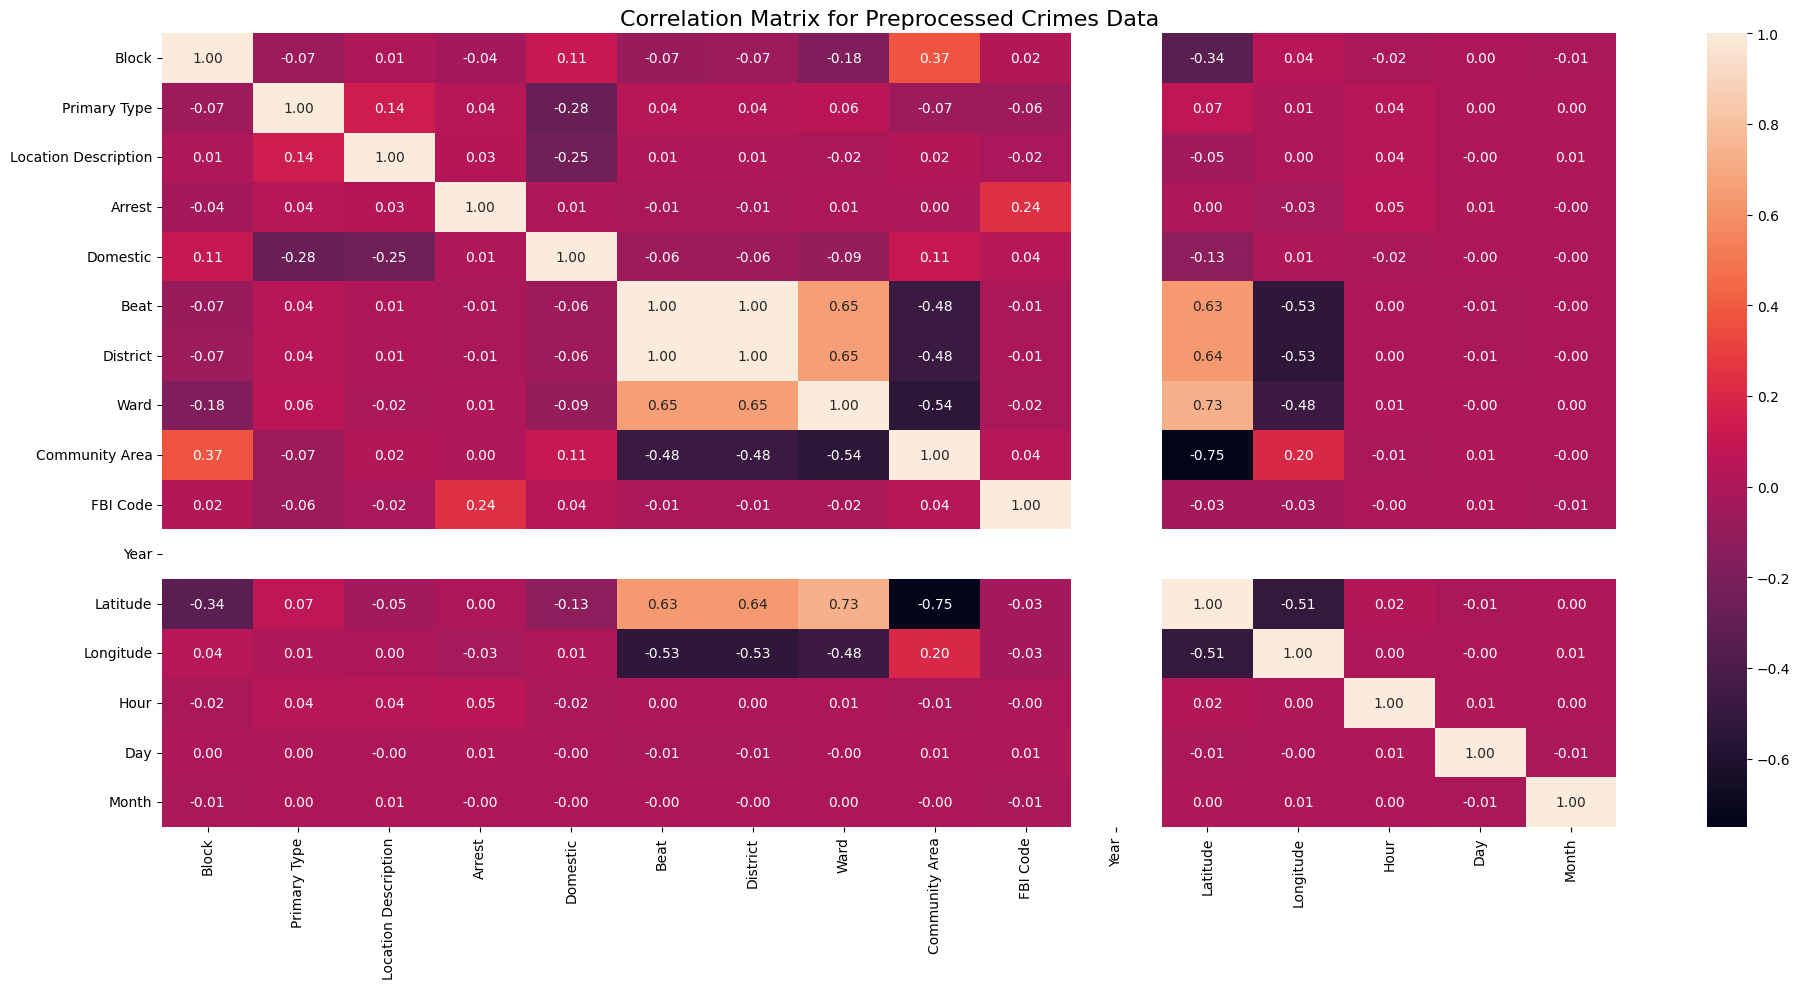

In [15]:
# Correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(PREPROCESS_DATA.corr(), annot=True, fmt=".2f")
plt.title("Correlation Matrix for Preprocessed Crimes Data", fontsize=16)
plt.tight_layout()
plt.show()

## Process Data


In [16]:
X = X.to_numpy()
y = y.to_numpy()

In [17]:
the_set = np.unique(y)
the_set

array([0, 1])

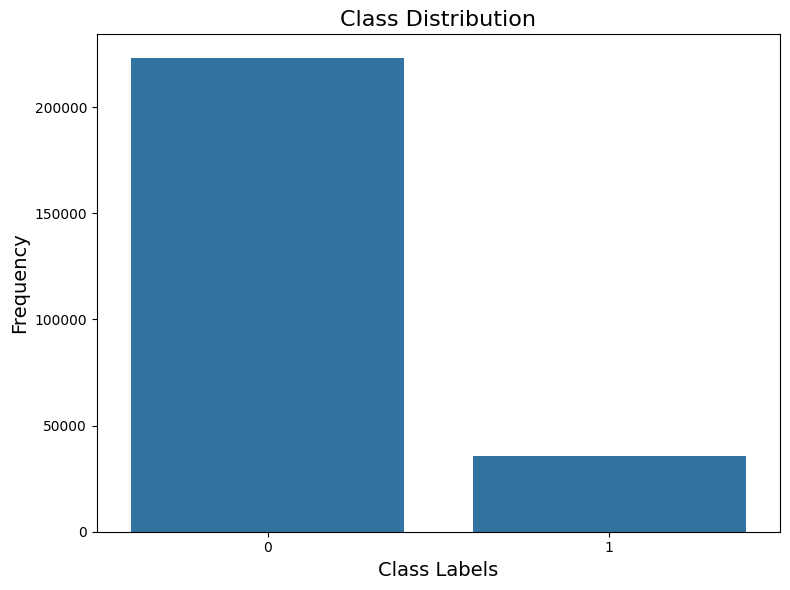

In [18]:
# Plot the classes
plt.figure(figsize=(8, 6))
sns.barplot(x=np.unique(y, return_counts=True)[0],
			y=np.unique(y, return_counts=True)[1])
plt.title("Class Distribution", fontsize=16)
plt.xlabel("Class Labels", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

In [19]:
print(X.shape)
print(y.shape)

(258809, 15)
(258809,)


In [20]:
random_seed = int(random.random() * 100)
random_seed

67

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed)

In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(207047, 15)
(51762, 15)
(207047,)
(51762,)


In [23]:
X_test.dtype, y_test.dtype

(dtype('float64'), dtype('int32'))

## Fix in case float64 error


In [24]:
# fix data type
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

In [25]:
X_train_tr = torch.from_numpy(X_train).to(device)
X_test_tr = torch.from_numpy(X_test).to(device)
y_train_tr = torch.from_numpy(y_train).to(device)
y_test_tr = torch.from_numpy(y_test).to(device)

## Normalization

- Normalizartion
- Standardization (\*)


In [26]:
x_means = X_train_tr.mean(0, keepdim=True)
x_deviations = X_train_tr.std(0, keepdim=True) + epsilon

In [27]:
x_means

tensor([[ 1.3573e+04,  1.4097e+01,  7.9384e+01,  1.8384e-01,  1.1581e+03,
          1.1351e+01,  2.3192e+01,  3.6188e+01,  1.0855e+01,  2.0240e+03,
          1.3560e-04, -9.5570e-04, -2.9660e-05,  2.9762e+00, -1.1628e-03]],
       device='cuda:0')

In [28]:
x_deviations

tensor([[8.5659e+03, 1.1408e+01, 4.0035e+01, 3.8746e-01, 7.0983e+02, 7.0932e+00,
         1.3954e+01, 2.1618e+01, 5.8133e+00, 1.0000e-04, 1.0003e+00, 1.0015e+00,
         9.9982e-01, 2.0032e+00, 9.9961e-01]], device='cuda:0')

## Create the DataLoader


In [29]:
train_list = [(X_train[i], y_train[i]) for i in range(X_train.shape[0])]
test_list = [(X_test[i],  y_test[i]) for i in range(X_test.shape[0])]

In [30]:
train_dl = torch.utils.data.DataLoader(
    train_list, batch_size=batch_size, shuffle=True)

In [31]:
all_test_data = X_test.shape[0]
test_dl = torch.utils.data.DataLoader(
    test_list,  batch_size=all_test_data, shuffle=True)

## Neural Network Architectures


In [32]:
class MLP_Net(nn.Module):
    def __init__(self, x_means, x_deviations):
        super().__init__()

        self.x_means = x_means
        self.x_deviations = x_deviations

        self.linear1 = nn.Linear(INPUT_DIM, 5)
        self.act1 = nn.ReLU()  # nn.Sigmoid()
        self.linear2 = nn.Linear(5, 2)
        self.act2 = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.25)

    # perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        y_pred = self.act2(x)

        return y_pred

In [33]:
class DL_Net(nn.Module):
    """Deep Learning network with 2 hidden layers"""

    def __init__(self, x_means, x_deviations):
        super().__init__()

        self.x_means = x_means
        self.x_deviations = x_deviations

        self.linear1 = nn.Linear(INPUT_DIM, 15)
        self.act1 = nn.ReLU()
        self.linear2 = nn.Linear(15, 9)
        self.act2 = nn.ReLU()
        self.linear3 = nn.Linear(9, 2)
        self.act3 = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.25)

    # perform inference
    def forward(self, x):

        x = (x - self.x_means) / self.x_deviations

        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        x = self.linear3(x)
        y_pred = self.act3(x)

        return y_pred

## Training Loop


In [ ]:
def training_loop(N_Epochs, model, loss_fn, opt):

    for epoch in range(N_Epochs):
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            # yb = torch.squeeze(yb, dim=1)

            y_pred = model(xb)
            # print(    yb.shape   )
            # print( y_pred.shape  )
            loss = loss_fn(y_pred, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

        if epoch % 20 == 0:
            print(epoch, "loss=", loss)

In [39]:
def print_metrics_function(y_test, y_pred):
    y_test = y_test.cpu()
    y_pred = y_pred.cpu()

    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(
        y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(
        y_true=y_test, y_pred=y_pred, average='weighted'))
    print('F1-measure: %.3f' %
          f1_score(y_true=y_test, y_pred=y_pred, average='weighted'))

## Training the MLP Model


In [36]:
mlp_model = MLP_Net(x_means, x_deviations).to(device)

opt = torch.optim.Adam(mlp_model.parameters(), lr=learning_rate)

# the y_test data can be integers and does not need to be one hot encoded with this function
loss_fn = nn.CrossEntropyLoss()

training_loop(N_Epochs, mlp_model, loss_fn, opt)

0 loss= tensor(0.5152, device='cuda:0', grad_fn=<NllLossBackward0>)
50 loss= tensor(0.4296, device='cuda:0', grad_fn=<NllLossBackward0>)


In [40]:
with torch.no_grad():
    for x_real, y_real in test_dl:
        x_real = x_real.to(device)
        y_real = y_real.to(device)

        y_pred = mlp_model(x_real)
        vals, indeces = torch.max(y_pred, dim=1)
        preds = indeces
        print_metrics_function(y_real, preds)

Accuracy: 0.88
Confusion Matrix:
[[43723   921]
 [ 5295  1823]]
Precision: 0.861
Recall: 0.880
F1-measure: 0.856


## Core Functions for Deep Learning


In [41]:
dl_model = DL_Net(x_means, x_deviations).to(device)
opt = torch.optim.Adam(dl_model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

training_loop(N_Epochs, dl_model, loss_fn, opt)

0 loss= tensor(0.4676, device='cuda:0', grad_fn=<NllLossBackward0>)
50 loss= tensor(0.3948, device='cuda:0', grad_fn=<NllLossBackward0>)


In [43]:
with torch.no_grad():
    for x_real, y_real in test_dl:
        x_real = x_real.to(device)
        y_real = y_real.to(device)

        y_pred = dl_model(x_real)
        vals, indeces = torch.max(y_pred, dim=1)
        preds = indeces
        print_metrics_function(y_real, preds)

Accuracy: 0.89
Confusion Matrix:
[[43875   769]
 [ 4710  2408]]
Precision: 0.883
Recall: 0.894
F1-measure: 0.876


## Export to Onnx

In [45]:
models = {
    "MLP_Model": mlp_model,
    "DL_Model": dl_model
}

for model_name, model in models.items():
    model.eval()

    dummy_input = torch.randn(1, INPUT_DIM).to(device)

    input_names = ["input1"]
    output_names = ["output1"]

    torch.onnx.export(
        model,
        dummy_input,
        f"{model_name}_Classification.onnx",
        verbose=False,
        input_names=input_names,
        output_names=output_names
    )

C:\Users\ikath\AppData\Local\Temp\ipykernel_34144\2919094841.py:14: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
